### Audio Data preprocessing 

In [29]:
import os
import sys
import tqdm

# Get the waveform from each video
from utils.file_format import convert_mp4_to_wav

path_to_audio = './../dataset_raw/Intro/Audio/'
path_to_video = './../dataset_raw/Intro/Video/'

for video in os.listdir(path_to_video):
    convert_mp4_to_wav(path_to_video + video, path_to_audio + video[:-4] + '.wav')


MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro9.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro2.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro0.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro6.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro8.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro10.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro5.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro1.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro3.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro7.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro4.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro11.wav


MoviePy - Done.


### Exploratory Audio Data Analysis

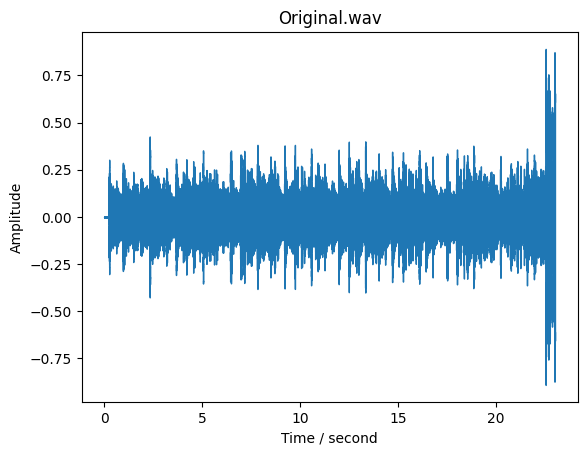

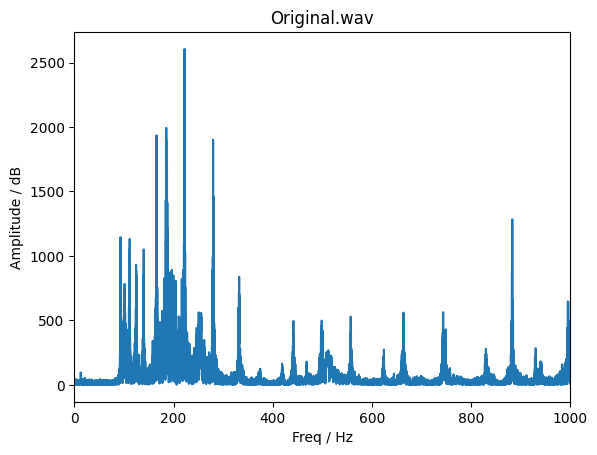

In [30]:
# Display original audio and features
from utils.data_visualization import plot_waveform, plot_frquency
import librosa
from IPython.display import Audio
import pandas as pd

audio_filepath = './../dataset_raw/Original.wav'
sample = 'Original.wav'

y, sr = librosa.load(audio_filepath, duration=20)
fig = plot_waveform(y, sr, sample)
plot_frquency(y, sr, sample)

# Playback
Audio(data=y, rate=sr)


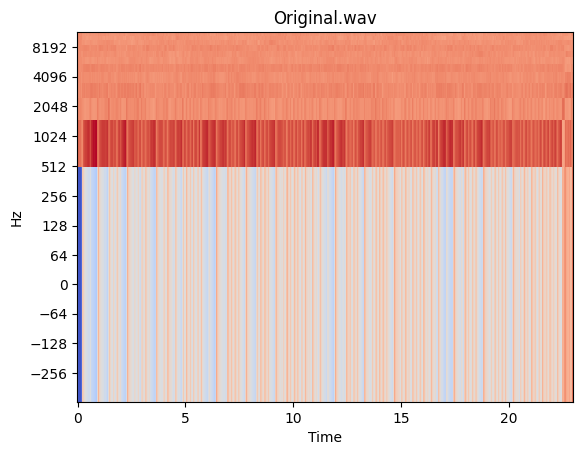

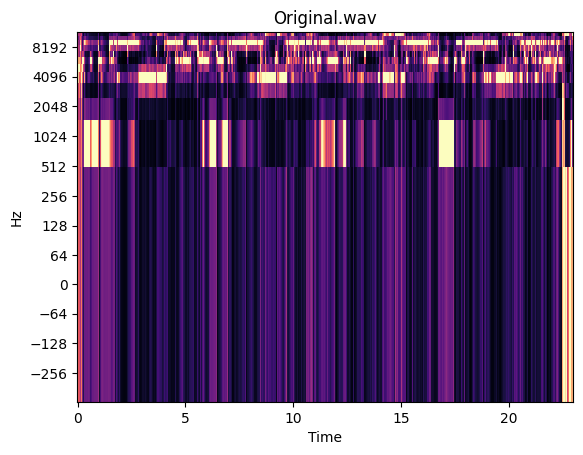

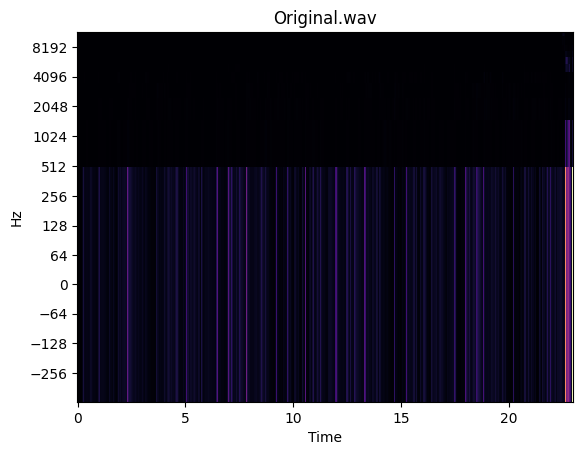

In [31]:
# Original Acoustic Features
from utils.data_visualization import plot_chromagram, plot_mel_spectrogram, plot_mfcc

plot_mfcc(y, sr, sample)
plot_chromagram(y, sr, sample)
plot_mel_spectrogram(y, sr, sample)

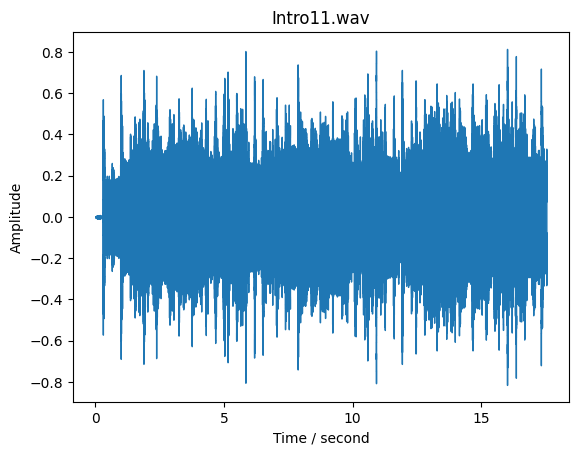

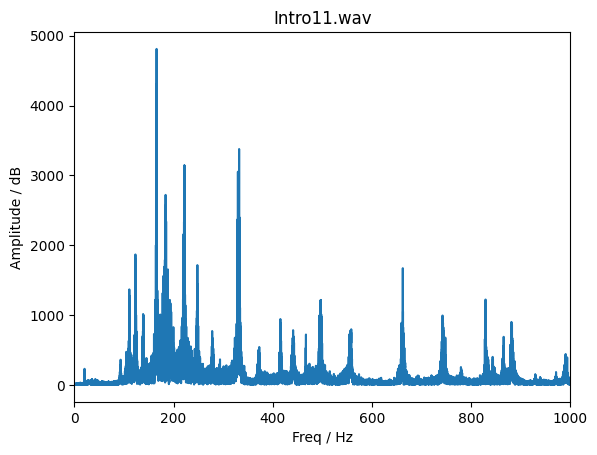

In [54]:
# Display sample audio
audio_filepath = './../dataset_raw/Intro/Audio/'
audio_files = os.listdir(audio_filepath)
audio_files = pd.DataFrame(audio_files)

sample = audio_files.sample(n=1)
sample = sample[0].values[0]

sample_path = audio_filepath + sample

y, sr = librosa.load(sample_path, duration=20)
fig = plot_waveform(y, sr, sample)
plot_frquency(y, sr, sample)

Audio(data=y, rate=sr)

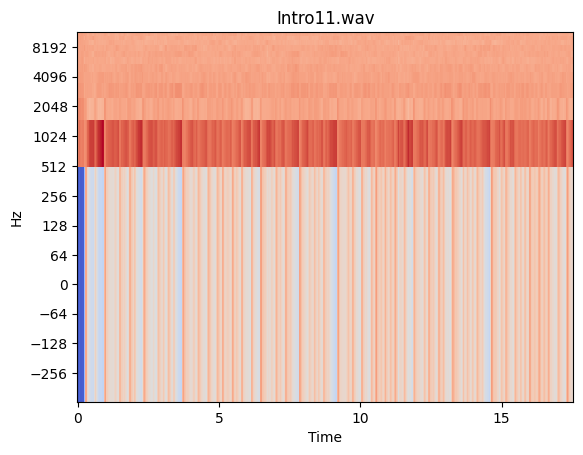

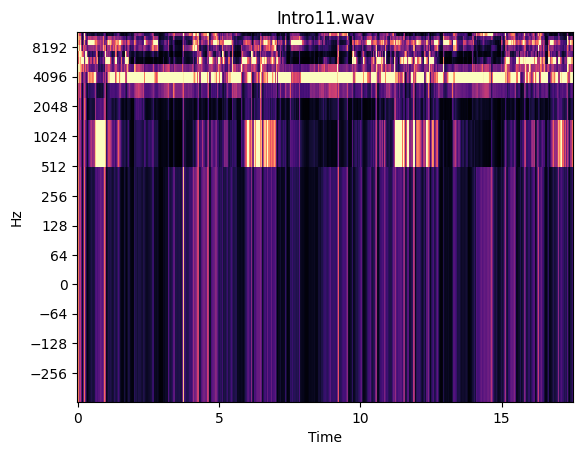

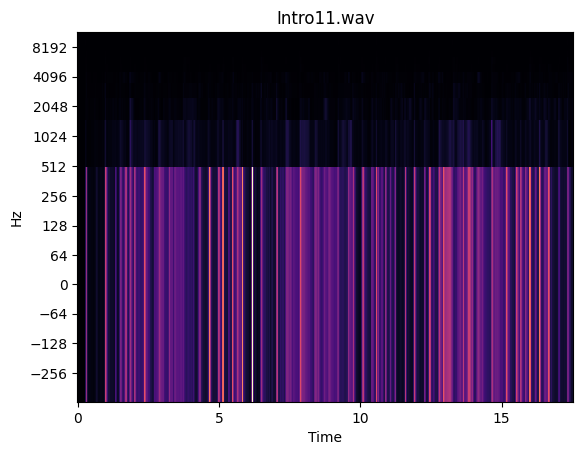

In [46]:
# Plot Audio Features

plot_mfcc(y, sr, sample)
plot_chromagram(y, sr, sample)
plot_mel_spectrogram(y, sr, sample)

In [55]:
# Generate Feature Matrix for Audio
from utils.audio_feature_extraction import generate_feature_matrix, get_chromagram, get_melspectrogram, get_mfccs
import numpy as np

audio_filepath = './../dataset_raw/Intro/Audio/'

os.listdir(audio_filepath)

features = []
for waveform in os.listdir(audio_filepath):
    waveform_path = audio_filepath + waveform

    y, sr = librosa.load(waveform_path, sr=32000, duration=23)
    df_melspect, mel_spectogram = get_melspectrogram(y, sr)
    df_chroma, chromagram = get_chromagram(y, sr)
    df_mfccs, mfccs = get_mfccs(y, sr)

    feature_matrix = generate_feature_matrix(df_melspectrogram=df_melspect, df_chroma=df_chroma, df_mfccs=df_mfccs)
    features.append(feature_matrix.values)

features

[array([[-3.54671404e-02, -2.93564424e-02, -2.84757894e-02,
         -2.81985532e-02, -2.77779438e-02, -2.78719626e-02,
         -2.77749225e-02, -2.79672705e-02, -2.56459191e-02,
         -2.35042553e-02, -2.37232726e-02, -2.48976760e-02,
          1.41279474e-02,  8.99864547e-03,  6.03601290e-03,
          7.30869966e-03,  4.98603703e-03,  2.64692307e-03,
          3.45207937e-03,  3.45969945e-03,  6.43812260e-03,
          9.32777580e-03,  7.12741073e-03,  6.73203589e-03,
          3.70066300e-05,  2.16336790e-04,  2.75098515e-04,
          2.44058901e-04,  2.59846885e-04,  4.10192006e-04,
          5.66975272e-04,  3.93508963e-04,  5.89772710e-04,
          5.60060609e-04,  5.38079476e-04,  4.46062884e-04],
        [ 1.14486674e-02,  1.32969851e-02,  1.34110553e-02,
          1.35468561e-02,  1.37126530e-02,  1.37481363e-02,
          1.38355400e-02,  1.33182546e-02,  1.40356040e-02,
          1.39249358e-02,  1.32899368e-02,  1.30800260e-02,
          8.25122371e-03,  5.07570338e-